### Functions
 - [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit)
 - [SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
 - [LDA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
 - [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

### Tutorial
- [In Depth: k-Means Clustering](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
- [Clustering US Laws using TF-IDF and K-Means](https://beckernick.github.io/law-clustering/)
- [The 5 Clustering Algorithms Data Scientists Need to Know](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)

In [697]:
import re
from string import punctuation

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans, MeanShift, DBSCAN, estimate_bandwidth
import nltk
import spacy
import gensim
from gensim.models.phrases import Phrases, Phraser
from nltk import word_tokenize
from nltk.corpus import stopwords


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def _get_stopwords():
    stpwords = stopwords.words('portuguese') + list(punctuation)
    rms = ['um', 'não', 'mais', 'muito']
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = NLP(re.sub(r'["\'@#%\(\)]', '', phrase), disable=['parser'])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != 'PUNCT':
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
                if palavra.pos_ in ['NOUN', 'ADJ', 'ADV']:
                    # clean_frase += [STEMMER.stem(palavra.text)]
                    clean_frase += [palavra.text]
                else:
                    clean_frase += [palavra.lemma_]
    return ' '.join(clean_frase)

# GLOBALS
NLP = spacy.load('pt')
STEMMER = nltk.stem.RSLPStemmer()
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

np.random.seed(12345)

%matplotlib inline

In [698]:
dc = NLP('perfeito', disable=['parser'])
print([(w.text, w.pos_, w.lemma_) for w in dc])

[('perfeito', 'NOUN', 'perfazer')]


In [795]:
frases_felicidade = [
#     ('Quando a tristeza bater na sua porta, abra um belo sorriso e diga: Desculpa, mas hoje a felicidade chegou primeiro!', 'FELICIDADE'),
#     ('Minha meta é ser feliz, não perfeito.', 'FELICIDADE'),
#     ('Que a felicidade vire rotina.', 'FELICIDADE'),
#     ('Felicidade é saber aproveitar todos os momentos como se fossem os últimos.', 'FELICIDADE'),
#     ('Eu não quero esperar até o final para ser feliz. Eu quero é ser feliz agora.', 'FELICIDADE'),
    ('Hoje estou muito feliz!', 'FELICIDADE'),
    ('O dia esta excelente, estou muito feliz.', 'FELICIDADE'),
    ('Abra um sorriso, que a felicidade chegou.', 'FELICIDADE')
]

frases_tristeza = [
#     ('O maior problema em acreditar nas pessoas erradas, é que um dia você acaba não acreditando em mais ninguém.', 'TRISTEZA'),
#     ('Não me deixe ir, posso nunca mais voltar.', 'TRISTEZA'),
#     ('Prefiro que enxerguem em mim erros com arrependimento do que uma falsa perfeição.', 'TRISTEZA'),
#     ('A morte é uma pétala que se solta da flor e deixa uma eterna saudade no coração.', 'TRISTEZA'),
#     ('Partiu para não mais voltar, e meu coração se partiu para não mais se recompor. Saudades de quem a morte levou para sempre.', 'TRISTEZA'),
#     ('Luto é o tempo necessário para a mente entender o sentimento de perda que o coração já sente.', 'TRISTEZA'),
#     ('Suas memórias são meu maior tesouro. Saudades suas, meu pai!', 'TRISTEZA'),
#     ('Meu amigo se foi para sempre. No seu lugar ficaram estas saudades eternas, que eternamente serão sentidas com muita tristeza.', 'TRISTEZA'),
#     ('Hoje o sol não brilhou, os pássaros não cantaram, os risos se calaram e as lágrimas rolaram em meu rosto. Meu coração sofre em silêncio.', 'TRISTEZA'),
    ('Lágrimas não doem, o que dói é o motivo que as fazem cair.', 'TRISTEZA')
]

frases_amor = [
#     ('Duvide do brilho das estrelas. Duvide do perfume de uma flor. Duvide de todas as verdades. Mas nunca duvide do meu amor.', 'AMOR'),
#     ('Amar é cuidar um do outro mesmo quando estamos zangados.', 'AMOR'),
#     ('O amor só é lindo, quando encontramos alguém que nos transforme no melhor que podemos ser.', 'AMOR'),
#     ('Quando o amor é verdadeiro, a distância vira mero detalhe.', 'AMOR'),
#     ('Não escolha a pessoa mais bonita do mundo. Escolha a pessoa que faz do seu mundo o mais bonito.', 'AMOR'),
    ('Pensando em você, me torno um poeta, olhando você, me torno um artista, imaginando nosso amor, me torno um sonhador', 'AMOR')
]

In [796]:
frases_felicidade_parsed = []
frases_tristeza_parsed = []
frases_amor_parsed = []
frases_felicidade_sentimento = []
frases_tristeza_sentimento = []
frases_amor_sentimento = []

# dc = NLP('é que um dia você acaba não acreditando em mais ninguém', disable=['parser'])
# print([(w.text, w.pos_, w.lemma_) for w in dc])

for frase, sentimento in frases_felicidade:
    frases_felicidade_parsed.append(tokenizer(frase))
    frases_felicidade_sentimento.append(sentimento)

for frase, sentimento in frases_tristeza:
    frases_tristeza_parsed.append(tokenizer(frase))
    frases_tristeza_sentimento.append(sentimento)

for frase, sentimento in frases_amor:
    frases_amor_parsed.append(tokenizer(frase))
    frases_amor_sentimento.append(sentimento)

print(frases_felicidade_parsed)
print(frases_tristeza_parsed)
print(frases_amor_parsed)

frases = frases_felicidade_parsed + frases_tristeza_parsed + frases_amor_parsed
ldocs = [f'D{i}' for i in range(len(frases))]

['hoje muito feliz', 'dia excelente muito feliz', 'abrir um sorriso felicidade chegar']
['lágrimas não doer dói motivo fazer cair']
['pensar tornar um poeta olhar tornar um artista imaginar amor tornar um sonhador']


In [834]:
vec_tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_tfidf = vec_tfidf.fit_transform(frases)

N_features = X_tfidf.shape[1]

frases_w2v = []
for frase in frases:
    bigram = []
    p_frase = word_tokenize(frase)
    for m, palavra in enumerate(p_frase):
        next_p = None
        try:
            next_p = p_frase[m+1]
        except:
            pass
        bigram += [f'{palavra}']
#         if next_p:
#             bigram += [f'{palavra} {next_p}']
    frases_w2v += [bigram]

model = gensim.models.Word2Vec(
    frases_w2v,
    sg=1,
    size=N_features,
    window=50,
    min_count=1,
    workers=10)
model.train(frases_w2v, total_examples=len(frases_w2v), epochs=1500)

vec_count = CountVectorizer(ngram_range=(1, 1))
X_count = vec_count.fit_transform(frases)
weights_count = pd.DataFrame(np.round(X_count.toarray().T, 5), index=vec_count.get_feature_names(), columns=ldocs)

print(X_tfidf.shape)
print(X_count.shape)
print(model.wv.vectors.shape)

# X_tfidf = X_tfidf + X_count
X_tfidf = np.asarray(np.dot(X_tfidf.toarray(), model.wv.vectors))
# X_tfidf = X_tfidf.toarray()

print("   Actual number of tfidf features: %d" % N_features)
weights_tfidf = pd.DataFrame(np.round(X_tfidf.T, 5), index=vec_tfidf.get_feature_names(), columns=ldocs)
display(weights_tfidf.head(15))

(5, 25)
(5, 25)
(25, 25)
   Actual number of tfidf features: 25


,D0,D1,D2,D3,D4
abrir,-0.26960,-0.33378,-0.79615,-0.41183,-1.14050
amor,0.56748,0.45733,0.60041,0.63459,0.90574
artista,0.63622,0.50353,0.33298,0.64246,0.47718
cair,0.25191,0.23025,0.15785,0.31004,0.19127
chegar,0.13537,0.08612,-0.07693,0.15639,-0.17792
dia,0.78902,0.71646,1.05013,0.92915,1.58203
doer,-0.73679,-0.54659,-0.35577,-0.75483,-0.50238
dói,-0.36953,-0.45830,-1.27205,-0.60313,-1.92419
excelente,0.45611,0.36731,0.53060,0.49294,0.82302
fazer,0.20404,0.16715,0.23141,0.21406,0.34289


In [841]:
alegria = ['feliz', 'felicidade', 'sorriso', 
           'perfeito', 'belo', 'excelente', 'perfeição', 
           'amor', 'verdadeiro', 'verdade', 'cuidar', 'lindo', 'tesouro']
alegria += ['abundante', 'acalmar', 'aceitável', 'aceitação', 'aclamar', 'aconchego', 'adesão', 'admirar', 'adorar', 'adoração', 'afeição', 'afeto', 'afetividade', 'afortunado', 'afável', 'agradar', 'ajeitar', 'altivez', 'altivo', 'alívio', 'amabilidade', 'amado', 'amar', 'amenizar', 'ameno', 'amigável', 'amistoso', 'amizade', 'amor', 'amável', 'animação', 'anseio', 'ansioso', 'apaixonado', 'apaziguar', 'aplausos', 'apoiar', 'aprazer', 'apreciar', 'aprovação', 'aproveitar', 'ardor', 'armirar', 'arrumar', 'atraente', 'atrair', 'atração', 'avidamente', 'avidez', 'belo', 'beleza', 'bem-estar', 'beneficiador', 'beneficência', 'benefício', 'benevocência', 'benignamente', 'benéfico', 'benígno', 'boa-intenção', 'bom', 'bom-humor', 'bondade', 'bondoso', 'bonito', 'bravura', 'brilhante', 'brilhantismo', 'brincadeira', 'brio', 'calma', 'calor', 'caridade', 'caridoso', 'carinho', 'cativar', 'charme', 'cheery', 'clamar', 'cofortar', 'coleguismo', 'comover', 'compaixão', 'companheirismo', 'compatibilidade', 'compatível', 'complacência', 'completar', 'compreensão', 'comédia', 'conclusão', 'concretização', 'condescendência', 'confiança', 'confortante', 'congratulação', 'conquistar', 'consentir', 'considerar', 'consideração', 'consolação', 'consolo', 'contentamento', 'contente', 'coragem', 'cordial', 'cuidadoso', 'cumplicidade', 'cômico', 'dedicação', 'deleitado', 'delicadamente', 'delicadeza', 'delicado', 'desejar', 'despreocupação', 'devoto', 'devoção', 'dignidade', 'diversão', 'divertido', 'elogiado', 'emocionante', 'emotivo', 'emoção', 'empatia', 'empolgação', 'empático', 'enamorar', 'encantado', 'encantar', 'encorajado', 'enfeitar', 'engraçado', 'entendimento', 'entusiasmadamente', 'entusiástico', 'esperança', 'esplendor', 'estima', 'estimar', 'estimulante', 'euforia', 'euforizante', 'eufórico', 'exaltar', 'excelente', 'excitar', 'expansivo', 'extasiar', 'exuberante', 'exultar', 'facilitar', 'familiaridade', 'fascinação', 'fascínio', 'favor', 'favorecer', 'favorito', 'felicidade', 'feliz', 'festa', 'festejar', 'festivo', 'fidelidade', 'fiel', 'filantropia', 'filantrópico', 'fraterno', 'fã', 'ganhar', 'generosidade', 'generoso', 'gentil', 'glorificar', 'glória', 'gostar', 'gostoso', 'gozar', 'gratidão', 'gratificante', 'gratificação', 'grato', 'hilariante', 'honra', 'humor', 'impressionar', 'incentivar', 'incentivo', 'inclinação', 'incrível', 'inspirar', 'interessar', 'interesse', 'irmandade', 'jovial', 'jovialidade', 'jubilante', 'júbilo', 'lealdade', 'legítimo', 'leveza', 'louvar', 'louvavelmente', 'louvável', 'lucrativo', 'lucro', 'majestoso', 'maravilhoso', 'melhor', 'namoro', 'nobre', 'obter', 'obteve', 'ode', 'orgulho', 'orgulhoso', 'paixão', 'parabenizar', 'paz', 'piedoso', 'positivo', 'prazenteiro', 'prazer', 'predileção', 'preencher', 'preferido', 'preferência', 'promissor', 'prosperidade', 'proteger', 'protetor', 'proteção', 'proveito', 'provilégio', 'querer', 'radiante', 'realizar', 'recomendável', 'recompensa', 'reconhecer', 'recrear', 'recreativo', 'recreação', 'regozijar', 'respeitar', 'ressuscitar', 'revigorar', 'risada', 'risonho', 'romantismo', 'romântico', 'saciar', 'saciável', 'satisfatoriamente', 'satisfatório', 'satisfazer', 'satisfação', 'satisfeito', 'seduzir', 'sedução', 'sereno', 'simpaticamente', 'simpático', 'sobreviver', 'sobrevivência', 'sorte', 'sortudo', 'sucesso', 'surpreender', 'tenro', 'ternura', 'torcer', 'tranquilo', 'triunfal', 'triunfante', 'triunfo', 'vanglória', 'vantagem', 'vantajoso', 'vencedor', 'veneração', 'ventura', 'vida', 'vigor', 'virtude', 'virtuoso', 'vitorioso', 'vitória', 'viver', 'vivo', 'zelo', 'zeloso', 'ávido', 'ânimo', 'ânsia', 'tesouro']
alegria = list(set(alegria))
tristeza = ['tristeza', 'problema', 'arrependimento', 'errar', 
            'não', 'falsa', 'morte', 'saudade', 'luto', 'distância', 
            'perda', 'memórias', 'dúvida', 'dói', 'lágrimas']
tristeza += ['abandonado', 'abandonar', 'abater', 'abatido', 'abatimento', 'abominável', 'aborrecer', 'aborrecimento', 'abortar', 'aceitação', 'adversidade', 'adverso', 'afastamento', 'afligir', 'aflito', 'aflição', 'agoniado', 'agoniar', 'amargo', 'amargor', 'amargura', 'amargurado', 'angustiado', 'angústia', 'ansiedade', 'apartado', 'arrepender', 'arrependidamente', 'arrependido', 'arrependimento', 'atormentado', 'atrito', 'azar', 'cabisbaixo', 'carrancudo', 'castigar', 'castigo', 'chorar', 'choro', 'choroso', 'chorão', 'circunspecção', 'circunspeção', 'coitado', 'compassivo', 'compungido', 'compunção', 'consternado', 'consternação', 'contristador', 'contrito', 'contrição', 'culpa', 'defeituoso', 'degradante', 'deplorável', 'deposição', 'depravado', 'depressivo', 'depressão', 'deprimente', 'deprimido', 'deprimir', 'derrota', 'derrubar', 'desalentar', 'desalento', 'desamparado', 'desamparo', 'desanimado', 'desanimar', 'desapontar', 'desconsolo', 'descontente', 'desculpas', 'desencorajar', 'desentusiasmar', 'desesperar', 'desespero', 'desestimular', 'desgaste', 'desgosto', 'desgraça', 'desiludir', 'desincentivar', 'desistir', 'desistência', 'deslocado', 'desmoralizar', 'desmotivar', 'desolado', 'desolar', 'desonra', 'despojado', 'desprazer', 'desprezo', 'desumano', 'desânimo', 'discriminar', 'disforia', 'disfórico', 'dissuadir', 'divórcio', 'doloroso', 'dor', 'dó', 'encobrir', 'enegrecer', 'enfadado', 'enlutar', 'entediado', 'entristecedor', 'entristecer', 'envergonhar', 'errante', 'erro', 'errôneo', 'escaldado', 'escurecer', 'escuridão', 'escuro', 'esmorecer', 'esquecido', 'estragado', 'estranho', 'execrável', 'extirpar', 'falsidade', 'falso', 'falta', 'flagelar', 'flagelo', 'fraco', 'fraqueza', 'fricção', 'frieza', 'frio', 'funesto', 'fúnebre', 'gelar', 'grave', 'horror', 'humilhar', 'importuno', 'inconsolável', 'indefeso', 'infelicidade', 'infeliz', 'infortúnio', 'inveja', 'isolado', 'isolamento', 'isolar', 'lacrimejante', 'lacrimoso', 'lamentar', 'lastimoso', 'luto', 'lutoso', 'lágrima', 'lástima', 'lúgubre', 'magoado', 'magoar', 'martirizar', 'martírio', 'mau', 'melancolia', 'melancólico', 'menosprezar', 'miseravelmente', 'misterioso', 'mistério', 'miséria', 'morre', 'morte', 'mortificado', 'mortificante', 'mortificação', 'mágoa', 'negligentemente', 'nocivo', 'nostalgia', 'nublar', 'obscuro', 'ofuscar', 'opressivo', 'opressão', 'oprimir', 'partida', 'pena', 'penalizar', 'penitencial', 'penitente', 'penitência', 'penoso', 'pensativo', 'penumbra', 'perder', 'perturbado', 'perverso', 'pervertar', 'pesar', 'pesaroso', 'pessimamente', 'piedade', 'pobre', 'porcamente', 'prejudicado', 'prejudicial', 'prejuízo', 'pressionar', 'pressão', 'prostração', 'quebrar', 'queda', 'queixoso', 'rechaçar', 'remorso', 'repressivo', 'repressão', 'reprimir', 'retidão', 'retitude', 'ruim', 'saudade', 'secreto', 'segregação', 'sentido', 'separação', 'seriedade', 'servil', 'sisudez', 'sisudeza', 'sobrecarga', 'sobrecarregado', 'sofrer', 'sofrimento', 'solidão', 'solitário', 'sombrio', 'soturno', 'sozinho', 'sucumbir', 'sujo', 'suplicar', 'suplício', 'só', 'timidez', 'tormento', 'torturado', 'torturar', 'trevas', 'triste', 'tristemente', 'tristonho', 'tédio', 'tímido', 'vazio',]
tristeza = list(set(tristeza))

alegria = [tokenizer(word) for word in alegria]
tristeza = [tokenizer(word) for word in tristeza]

def retorn_palavras(palavras, size):
    r_words = {}
    for i, word in enumerate(palavras):
        for index, word2 in enumerate(weights_tfidf.index):
            if word in word2:
                r_words[word2] = weights_tfidf.iloc[index].values
    return np.asarray(list(r_words.values())).T

r_words_1 = retorn_palavras(alegria, len(frases))
r_words_2 = retorn_palavras(tristeza, len(frases))

X = np.column_stack((r_words_1, r_words_2))
n = len(model.wv.vectors[1])
# X = TruncatedSVD(n_components=29, random_state=0).fit_transform(X)
# print(X.shape)
X = LatentDirichletAllocation(n_components=n, random_state=0).fit_transform(softmax(X))

In [842]:
k = 3
kmeans = KMeans(n_clusters=k, n_init=50, max_iter=500, random_state=0, n_jobs=5)
J = kmeans.fit_transform(X)

# kmeans = DBSCAN(eps=.05, min_samples=3)
# kmeans.fit(X)
# k = len(set(kmeans.labels_))

# kmeans = MeanShift(bandwidth=estimate_bandwidth(X, quantile=0.2, n_samples=500), cluster_all=True, n_jobs=5)
# kmeans.fit(X)
# k = len(set(kmeans.labels_))

In [843]:
print('labels:', kmeans.labels_)
labels_unique = np.unique(kmeans.labels_)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

labels: [1 1 2 1 0]
number of estimated clusters : 3


In [844]:
cluster_assignments_dict = {}

for i in set(kmeans.labels_):
    current_cluster = [frases[x] for x in np.where(kmeans.labels_ == i)[0]]
    cluster_assignments_dict[i] = current_cluster

for n in range(k):
    print('-- Cluster {0}'.format(n))
    for frase in cluster_assignments_dict[n]:
        if frase in frases_felicidade_parsed:
            print('FELICIDADE', frase)
        elif frase in frases_tristeza_parsed:
            print('TRISTEZA', frase)
        elif frase in frases_amor_parsed:
            print('AMOR', frase)

-- Cluster 0
AMOR pensar tornar um poeta olhar tornar um artista imaginar amor tornar um sonhador
-- Cluster 1
FELICIDADE hoje muito feliz
FELICIDADE dia excelente muito feliz
TRISTEZA lágrimas não doer dói motivo fazer cair
-- Cluster 2
FELICIDADE abrir um sorriso felicidade chegar


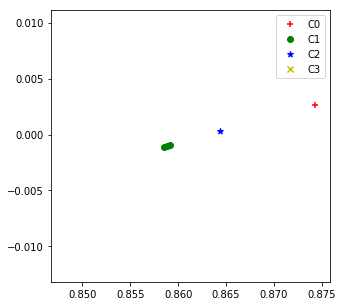

In [840]:
# tfs_embedded = TSNE(n_components=k, perplexity=50, verbose=2).fit_transform(tfs_reduced)
J = TruncatedSVD(n_components=2, random_state=0).fit_transform(X)

fig = plt.figure(figsize = (5, 5))
for i in range(J.shape[0]):
    if kmeans.labels_[i] == 0:
        c1 = plt.scatter((J[i, 0]), (J[i, 1]), c='r', marker='+')
    elif kmeans.labels_[i] == 1:
        c2 = plt.scatter((J[i, 0]), (J[i, 1]), c='g', marker='o')
    elif kmeans.labels_[i] == 2:
        c3 = plt.scatter((J[i, 0]), (J[i, 1]), c='b', marker='*')
    elif kmeans.labels_[i] == 3:
        c4 = plt.scatter((J[i, 0]), (J[i, 1]), c='y', marker='x')
plt.legend([c1, c2, c3, c4], ['C0', 'C1', 'C2', 'C3'])
plt.show()